# Exercise 3 - CNNs, ResNets and LR-Scheduling

 * Deep Learning for Computer Vision – Winter Term 2022/23
 * Organizers: Anwai Archit, Laura Hansel, Michaela Vystrcilova, Constantin Pape
 * Tutors: Anwai Archit, Mai Elshazly, Andreas Schneider, Fabio Seel, Shashwat Sridhar
 * Due date: **Monday, Dec 5, before 14:00**

### Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**

### Topics

In this exercise sheet, you will:
- work again with CIFAR-10
- implement a 1-layer CNN
- compare MLP and CNN
- vary architecture to improve model performance
- implement a ResNet for CIFAR-10
- learn about learning rate scheduling
- [learn about transfer learning]

*We are looking forward to seeing your solutions! Have fun!*

# IMPORTANT SUBMISSION INSTRUCTIONS

You should work on the exercises in groups of 2-3. It is on you how you collaborate, but please make sure that everyone contributes equally and also that you understand all the solutions.
You will be asked to present your group's solution in the tutorials and you should be well prepared to present any part of it.

- When you've completed the exercise, download the notebook and rename it to ```<surname1>_<surname2>_<surname3>.ipynb```.
- Only submit the Jupyter Notebook (ipynb file). No other file is required. Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 3`.
- Make only one submission of the exercise per group.
- The deadline is strict.
- In addition to the submissions, every member of your group should be prepared to present the exercise in the tutorials.

Implementation
- Do not change the cells which are marked as "DO NOT CHANGE", similarly write your solution to the marked cells.

### Imports

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
import torchvision
from torchvision import datasets, transforms, models
import fastprogress
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import time

## 1. Setup

You can use the functions to grab the data, split the sets and create the dataloaders, etc. given to you at exercise sheet 2.

It is good practice to store functions that are constantly needed again in a separate file such that instead of copy-pasting the cells into each exercise notebook, you can use the python file containing the functions and import it in the notebooks.

If you work with Kaggle (which is recommended) you have to mount the drive first and create a path to your python module (or download the file from your drive).

#### **TODO**
Create a file named 'utils.py' and import it here. You can import any package necessary.

In [3]:
# TODO import utils.py
from utils import *

## 2. Load dataset, create dataloader, etc.

#### **TODO**
Call the functions of 'utils.py' to instantiate the train-, test- and validation datasets along with their dataloaders.

In [4]:
# TODO define device
device = get_device()

# Get number of cpus to use for faster parallelized data loading
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')

cuda available: True ; cudnn available: True ; num devices: 2
Using device Tesla T4
2 CPUs available


In [5]:
data_dir = 'data'
batch_size = 256

# TODO grab data, generate split, init data loaders
seed = 42
trainset, testset, dataset_mean, dataset_std = grab_data(data_dir)
trainset, valset = generate_train_val_data_split(trainset,split_seed=seed)
trainloader, valloader, testloader= init_data_loaders(trainset, valset,testset,batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


#### **TODO** 
Define the loss function. We use the cross entropy loss again.

In [6]:
# TODO define loss function
loss_function = nn.CrossEntropyLoss()

In [7]:
x,y = next(iter(trainloader))
x.shape

torch.Size([256, 3, 32, 32])

## 3. Simple 1-layer CNN model

### **TODO**
- Define the model.

The first step to training a model is defining its architecture. 
Define a sequential model with following structure:
*   Convolutional layer with 32 filters, kernel size of 5*5 and stride of 1.
*   Max Pooling layer with kernel size of 2*2 and default stride.
*   ReLU Activation Layers.
*   Linear layer with output of 512.
*   ReLU Activation Layers.
*   A linear layer with output of 10.

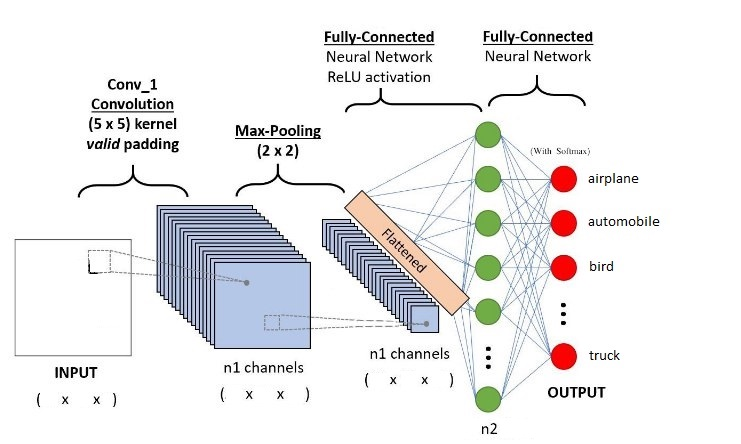

#### **Questions**

- What are the input dimensions?
- What are the dimensions of the feature maps?
- What are the dimensions after pooling?
- What is the value for n2 (in_features)?
- What is the number of parameters for conv_1?

**Your answers here**
- 1) 32x32x3
- 2) 32x28x28
- 3) 32x14x14
- 4) 32x14x14x512
- 5) 32x5x5

In [8]:
# TODO define model
class CNN1(nn.Module):
    """1 layer-CNN"""
    def __init__(self):
        super(CNN1, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 5, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32*14*14, 512),
            nn.ReLU(),
            nn.Linear(512,10)
        )
    def forward(self, x):
        x = self.model(x)
        return x

#### **TODO**

- Train the model for 10 epochs. Use a learning rate of 0.001.
- Plot the results of accuracy and loss as you did in exercise sheet 2.

Finished training after 172 seconds.


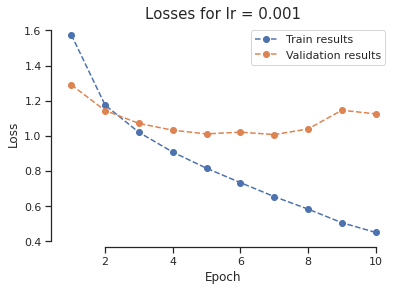

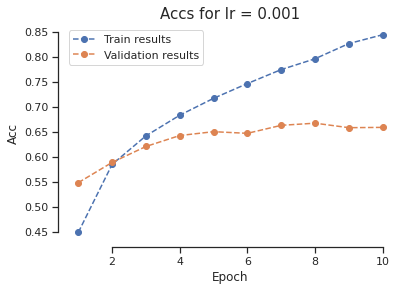

best val_loss: 1.0078356549143792 at epoch: 6
best val_acc: 0.6673 at epoch: 7


In [9]:
# TODO train and plot
lr = 1e-3
num_epochs = 10
model = CNN1()
model=model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=None, verbose=False)
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

In [10]:
print(model)

CNN1(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=6272, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
)


#### **TODO**
Compare results to MLP. What can you observe?

- the model even after 1 epoch is better than the best MLP model
- it reaches almost 70% after 8 epochs
- it starts to flatten fast

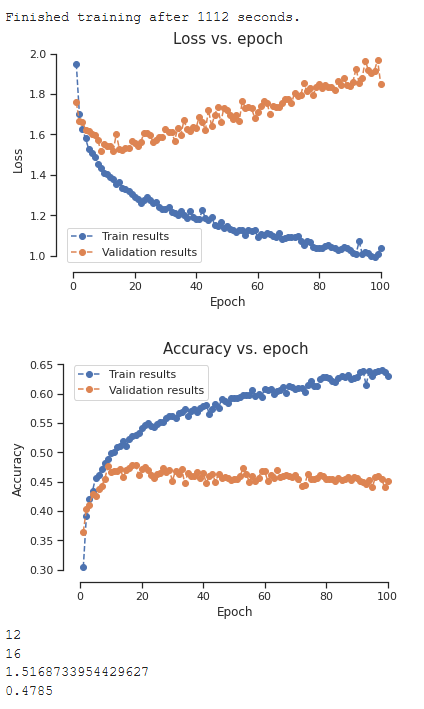

#### **TODO** 
Train longer (ca. 60 epochs), plot again.

Finished training after 973 seconds.


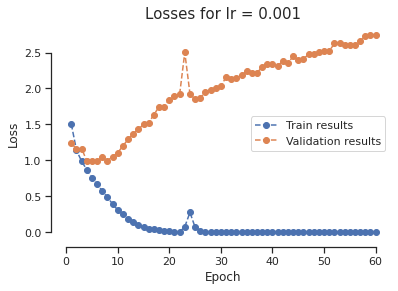

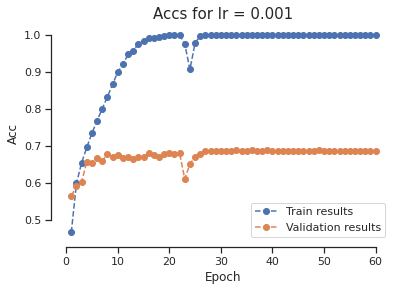

best val_loss: 0.9894489869475365 at epoch: 5
best val_acc: 0.6889 at epoch: 35


In [11]:
# TODO train and plot
num_epochs = 60
model = CNN1()
model=model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=None, verbose=False)
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

#### **Questions**
- Why is that not an optimal model?
- What could be improved?

- it doesnt learn after 4 epochs
- the model architecture could be improved, with more layers
- there could be an weight decay
- batch normalization

## 4. CNN model with more convolutional layers

#### **TODO**
Define the architecture displayed in the graphic.

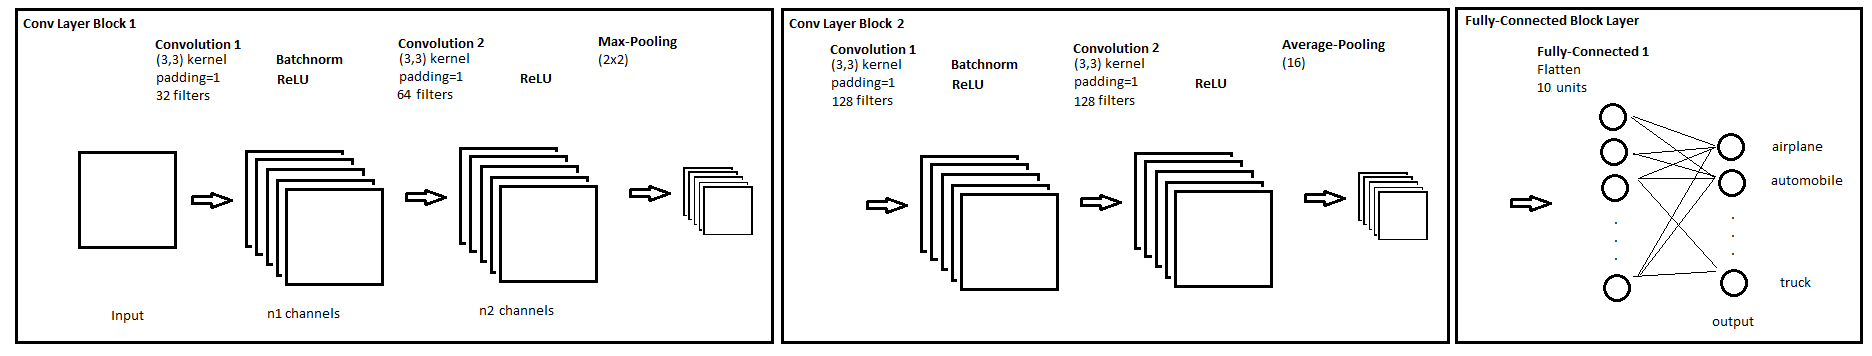

#### **Questions**

- Padding is used in the convolutional layers. What does that mean, which variants exist and how does it influence the dimensions of the feature maps?
- What does padding=1 mean in the case of the network displayed above?
- What are the dimensions of the feature maps after the 1. conv layer?
- What are the dimensions of the feature maps after the 2. conv layer?
- What ist the receptive field size after the first two convolutions?
- What is the value for the in_features for the fully-connected layer?
- What is the number of parameters of *Conv Layer block 1*?

- 1) Padding for Convolutional layer, refers to the amount of pixels added to an image on the sides.
    - for zero the image will be the same as before
    - if its 1, you expand your image to one pixel on the edge
    - this is called "same" padding and the output image will have the same size.
- 2) as explained above, it will expand the picture by 1 on the edge
- 3) 32x32x32
- 4) 64x32x32
- 5) 5
- 6) 128x10 ?
- 7) 32x3x3x3+64x3x3

In [12]:
#TODO define model 2
class CNN2(nn.Module):
    """2 layer-CNN"""
    def __init__(self):
        super(CNN2, self).__init__()
        # first block note: sequentiel
        self.convBlock1=nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # second block
        self.convBlock2=nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.ReLU(),
            nn.AvgPool2d(16),
            nn.Flatten(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = self.convBlock1(x)
        x = self.convBlock2(x)
        return x

In [13]:
model1 = CNN2()
print(model1)

CNN2(
  (convBlock1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convBlock2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=16, stride=16, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=128, out_features=10, bias=True)
  )
)


#### **TODO** 

- train the new net (30 epochs, lr=0.1), plot the results, and compare the results to the 1-layer CNN
- explain why you observe these results

Finished training after 536 seconds.


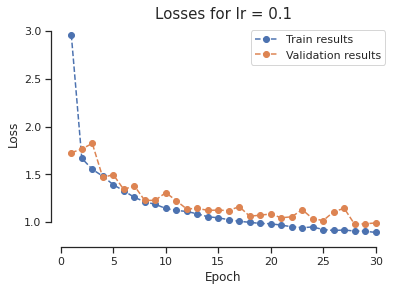

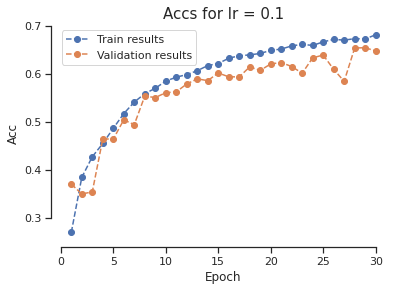

best val_loss: 0.975191205739975 at epoch: 27
best val_acc: 0.6539 at epoch: 28


In [14]:
# TODO train and plot
num_epochs = 30
lr = 1e-1
model = CNN2()
model=model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=None, verbose=False)
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

- it learned longer, but peaked almost the same accuracy.
- the lr is pretty high, which leads to fast increases at the beginning but wont lead to the optimal acc
- one could decrease the lr


## 5. ResNet architecture

"*Deeper neural networks are more difficult to train.  We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously.*" [ https://arxiv.org/pdf/1512.03385.pdf]

That was the intention of He et al. to develop residual networks.

A ResNet is built of blocks which are called the *Residual Blocks*. 
A residual block uses *skip connections* - shortCuts — to jump over some layers to skip some activations.
The Resnet skips connections via addition.

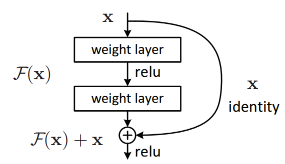

#### **Questions**
- Which problems do using skip connections solve?
- Why is a residual network called residual? 
- When is the advantage of ResNets over 'normal' CNNs most visible?

**Your answers here**
- it solves vanishing gradient, which occur at a high number of layers
    - also it uses less memory which help to use it on weaker devices
- its called risidual sincce it uses the risidual of the last layer as a component for following layer
- also its visible if you compare in to CNN witha lot of layers

#### **TODO**
- write a class **ResidualBlock(nn.Module)** where you define the blocks used in the ResNet
- write a class **ResNet(nn.Module)** where you define the model
- train the model
- plot results

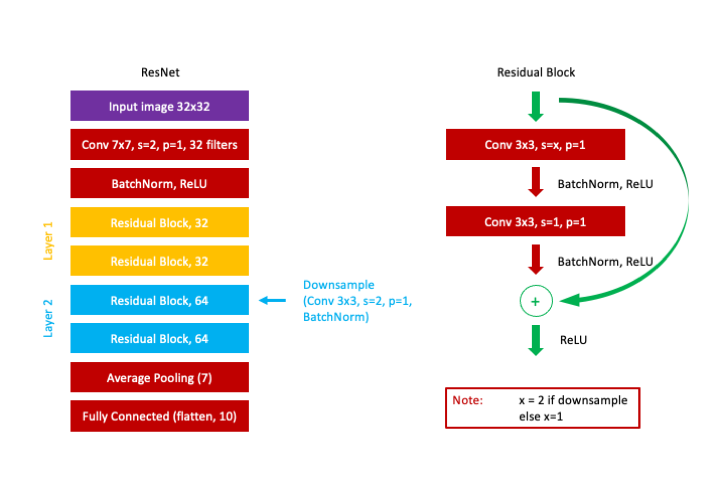

**Hints**

- The downsampling in this ResNet happens between layer 1 and layer 2. In this step, the channel size is increased (32 -> 64) and the image resolution is downsampled by strided convolution (stride=2 in the Conv2d layers).
- For the adding part, the dimensions obviously have to be the same. This is accomplished by using stride=2 in the first Conv2d layer of the block while the second layer does not change the dimensions.
- The average-pooling layer has kernel size 7.
- For you to ensure everything works fine, here are the shapes in the form [(batchsize), x, y, channel] where I discard batchsize, because it does not change.
32x32x3 -> conv 7x7 -> 14x14x32 -> layer 1 -> 14x14x32 -> layer2 -> 7x7x64 -> avpool(7) -> 1x1x64 -> linear(64, 10)

In [15]:
# TODO write a class ResidualBlock(nn.Module) where you define the blocks used in the ResNet
class ResidualBlock(nn.Module):
    """Residual Block"""
    def __init__(self,in_channel,out_channel,downsample=True):
        super(ResidualBlock, self).__init__()
        if downsample:
            s=2
            self.downsample = nn.Conv2d(in_channel,out_channel,1,2)
        else:
            s=1
        self.down = downsample
        self.ResBlock = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 3, s, 1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.Conv2d(out_channel, out_channel, 3, 1, 1),
            nn.BatchNorm2d(out_channel)
        )       
    def forward(self,x):
        if self.down:
            output = F.relu(self.downsample(x) + self.ResBlock(x))
        else:
            output = F.relu(x + self.ResBlock(x))
        return output

In [16]:
# TODO write a class ResNet(nn.Module) where you define the model
class ResNet(nn.Module):
    """ResNet Model"""
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 7, 2, 1)
        self.bnorm1 = nn.BatchNorm2d(32)
        self.block32_1 = ResidualBlock(32,32,downsample=False)
        self.block32_2 = ResidualBlock(32,32,downsample=False)
        self.block64_1 = ResidualBlock(32,64)
        self.block64_2 = ResidualBlock(64,64,downsample=False)
        self.avgpool = nn.AvgPool2d(7)
        self.fc1 = nn.Linear(64, 10)
    def forward(self,x):
        x = F.relu(self.bnorm1(self.conv1(x)))
        x = self.block32_2(self.block32_1(x)) #layer 1
        x = self.block64_2(self.block64_1(x)) #layer 2
        m = nn.Flatten()
        x = self.fc1(m(self.avgpool(x)))
        return x
        

In [17]:
# TODO train ResNet, using the architecture laid out in the comments and figures above
num_epochs = 30
lr = 1e-1
model = ResNet()
model=model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=None, verbose=False)

Finished training after 503 seconds.


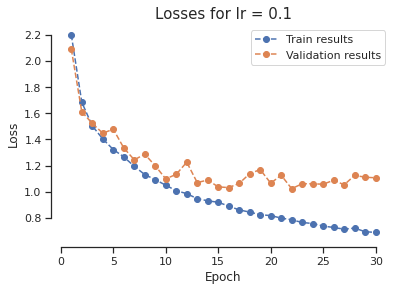

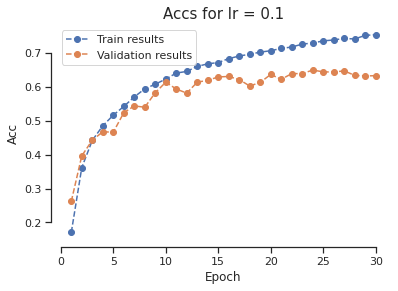

best val_loss: 1.0234259158372878 at epoch: 21
best val_acc: 0.6497 at epoch: 23


In [18]:
# TODO plot loss and accuracy for training and validation set
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

#### **Questions**
- Does the performance increase compared to the CNNs you trained before? Why/Why not?
- Compare the runtime of CNN and ResNet.

**Your answers here**
- no it got worse somehow
- same runtime

## 6. Explore Learning Rate Scheduling

Learning rate scheduling is a mechanism to adjust the learning rate.

*torch.optim.lr_scheduler* provides several methods based on the number of epochs. Learning rate scheduling should be applied after optimizer’s update.

#### **TODO**
- change run_training and extend to use scheduler for learning rate
- use StepLR (https://pytorch.org/docs/stable/optim.html), use the ResNet, train for 10 epochs. Start with a learning rate of 0.1.


#### **Questions**

- Try step size 1, gamma 0.1
    - How does it change the learning rate?
    - what do you observe regarding performance?
- Try step size 1, gamma 0.9, what do you observe?
    - How does it change the learning rate?
    - what do you observe regarding performance?
- What can you conclude of this experiment regarding the synergy of step size and gamma to get a good schedule?

**Your answers here**

In [19]:
# TODO change run_training (you can copy the code from utils.py here and create a new method here 
# or just change/create a new method it in the python file)

Finished training after 169 seconds.


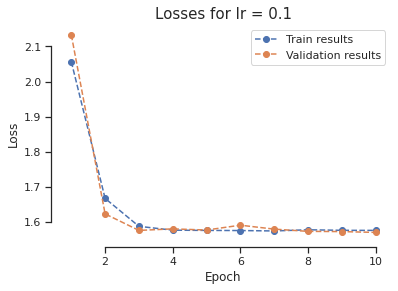

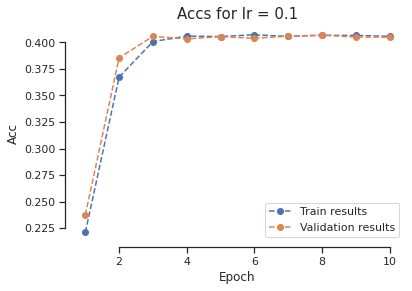

best val_loss: 1.5702223002910614 at epoch: 9
best val_acc: 0.4068 at epoch: 7


In [20]:
# TODO train and plot with step size 1, gamma 0.1
lr = 1e-1
model = ResNet()
model=model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
num_epochs = 10


train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=None, verbose=False,scheduler=scheduler)
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

Finished training after 168 seconds.


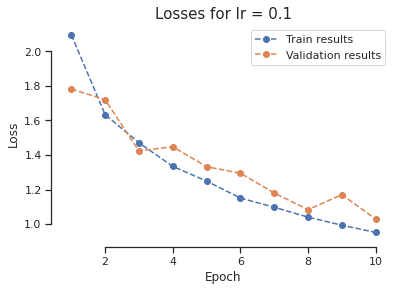

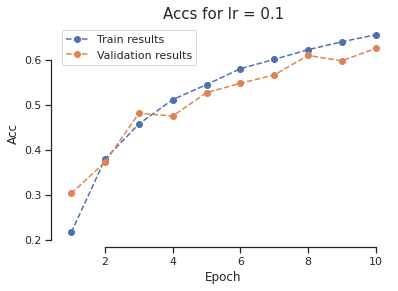

best val_loss: 1.0293415531516075 at epoch: 9
best val_acc: 0.6259 at epoch: 9


In [21]:
# TODO train and plot with step size 1, gamma 0.9
model = ResNet()
model=model.to(device)
lr = 1e-1
num_epochs = 10


optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=None, verbose=False,scheduler=scheduler)
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

#### **TODO** 

Use step size 15, gamma 0.1. Train for 30 epochs.

Finished training after 499 seconds.


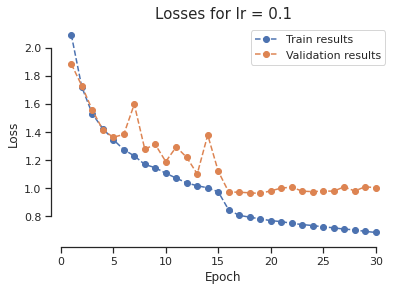

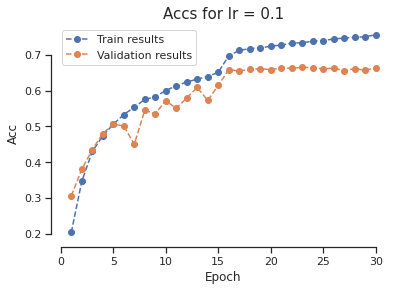

best val_loss: 0.9633210569620132 at epoch: 18
best val_acc: 0.6655 at epoch: 22


In [22]:
# TODO train and plot with step size 15, gamma 0.1, 30 epochs.
model = ResNet()
model=model.to(device)
lr = 1e-1
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
num_epochs = 30

train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=None, verbose=False,scheduler=scheduler)
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

#### **Questions**
- Does it improve performance?
- What can you observe in the plots?

**Your answers here**

## [7. Optional LR-Scheduling]

#### **TODO**
- try two more scheduler: ExponentialLR and ReduceLROnPlateau 
- vary the parameters, which work best?
- does it improve performance compared to no scheduler?
- does it improve performance compared to StepLR?

**Your answers here**

Finished training after 170 seconds.


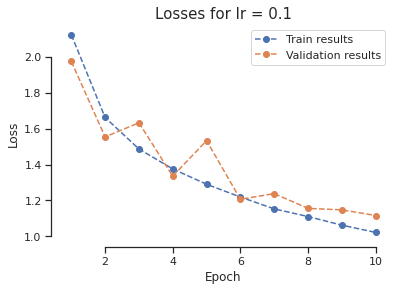

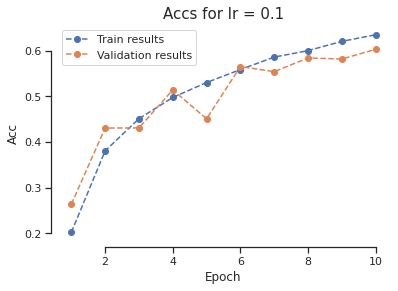

best val_loss: 1.1153603211045264 at epoch: 9
best val_acc: 0.603 at epoch: 9


In [23]:
# TODO train and plot
model = ResNet()
model=model.to(device)
lr = 1e-1
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
num_epochs = 10

train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=None, verbose=False,scheduler=scheduler)
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

Finished training after 169 seconds.


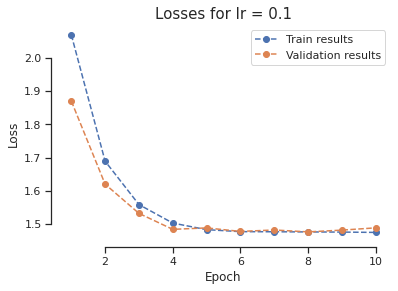

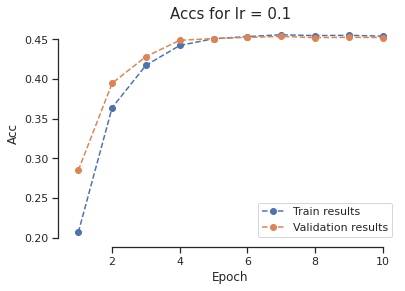

best val_loss: 1.4765162587165832 at epoch: 7
best val_acc: 0.4537 at epoch: 6


In [24]:
model = ResNet()
model=model.to(device)
lr = 1e-1
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.3)
num_epochs = 10

train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=None, verbose=False,scheduler=scheduler)
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

Finished training after 343 seconds.


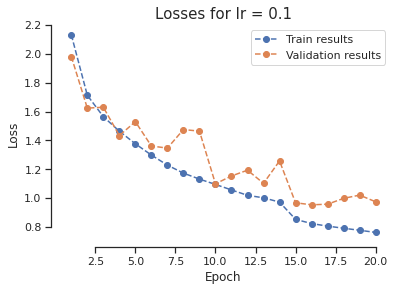

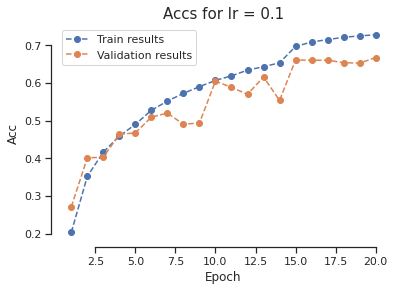

best val_loss: 0.9534824043512344 at epoch: 15
best val_acc: 0.6676 at epoch: 19


In [25]:
model = ResNet()
model=model.to(device)
lr = 1e-1
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=3,factor=0.3)
num_epochs = 20

train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=None, verbose=False,scheduler=scheduler)
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

Finished training after 339 seconds.


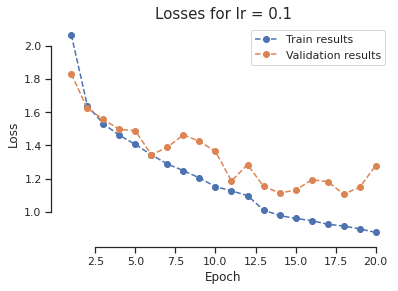

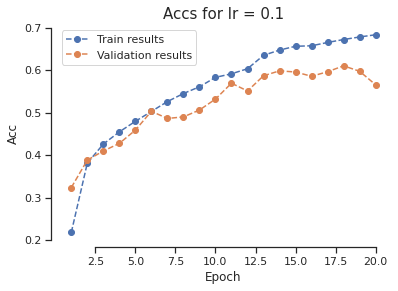

best val_loss: 1.1075836092233657 at epoch: 17
best val_acc: 0.6101 at epoch: 17


In [26]:
model = ResNet()
model=model.to(device)
lr = 1e-1
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'max',factor=0.5)
num_epochs = 20

train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=None, verbose=False,scheduler=scheduler)
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

Finished training after 332 seconds.


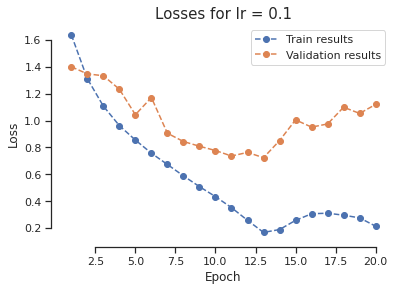

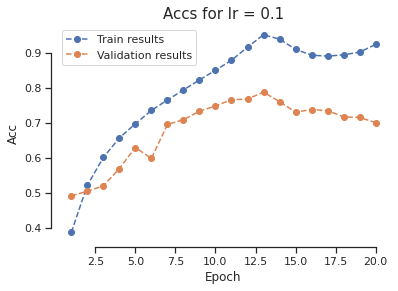

best val_loss: 0.7240466505289078 at epoch: 12
best val_acc: 0.7873 at epoch: 12


In [27]:

model = ResNet()
model=model.to(device)
lr = 1e-1
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,base_lr=1e-2,max_lr=1e-1,step_size_up=6)
num_epochs = 20

train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=None, verbose=False,scheduler=scheduler)
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

Finished training after 329 seconds.


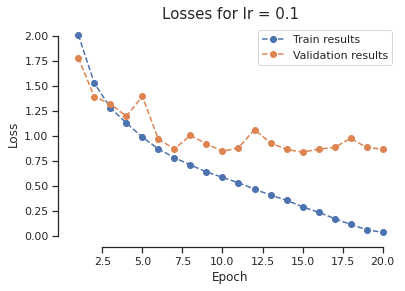

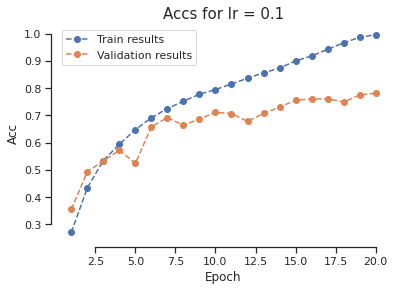

best val_loss: 0.835374853014946 at epoch: 14
best val_acc: 0.7819 at epoch: 19


In [28]:
model = ResNet()
model=model.to(device)
lr = 1e-1
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.7)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,base_lr=1e-3,max_lr=1e-1,step_size_up=10)
num_epochs = 20

train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=None, verbose=False,scheduler=scheduler)
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

Finished training after 649 seconds.


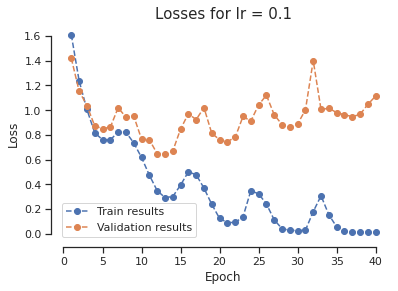

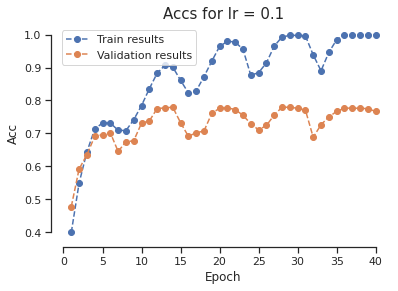

best val_loss: 0.6464880160987377 at epoch: 12
best val_acc: 0.7798 at epoch: 13


In [29]:
model = ResNet()
model=model.to(device)
lr = 1e-1
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=4)
num_epochs = 40

train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=None, verbose=False,scheduler=scheduler)
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

## [8. Optional Transfer Learning]

### **TODO**

- load a pretrained ResNet from torchvision
- freeze the parameters so that the gradients are not computed
- replace the last fully-connected layer
- fine-tune the model
- plot the results again and compare to approaches before
    - is a better performance reached? why/why not?
    - does it take more/less time to fine-tune compared to train a resnet?

**Your answers here**
- it reached about 50% which is worse
- it learned fast
- 

In [30]:
# TODO do transfer learning with resnet on cifar10
model = torchvision.models.resnet152(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
modelOutputFeats = model.fc.in_features
model.fc = nn.Linear(modelOutputFeats, 10)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Finished training after 249 seconds.


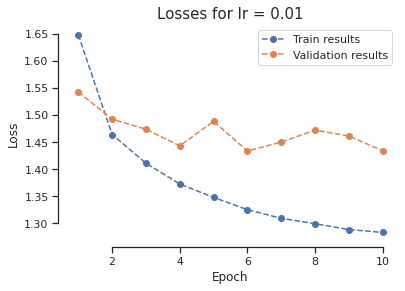

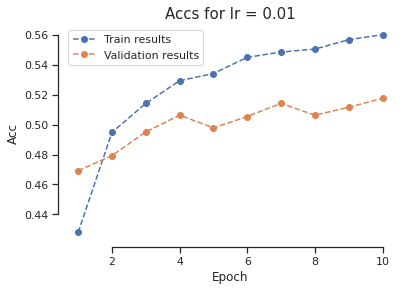

best val_loss: 1.4337746232748032 at epoch: 5
best val_acc: 0.5177 at epoch: 9


In [31]:
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr,momentum=0.9)
#exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
num_epochs = 10

train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=None, verbose=False,scheduler=None)
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

In [32]:
model = torchvision.models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
modelOutputFeats = model.fc.in_features
model.fc = nn.Linear(modelOutputFeats, 10)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Finished training after 370 seconds.


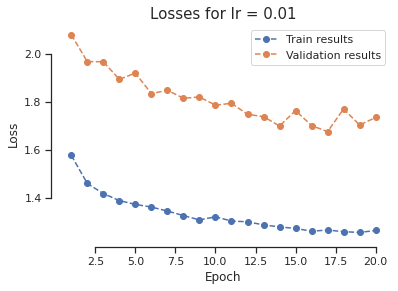

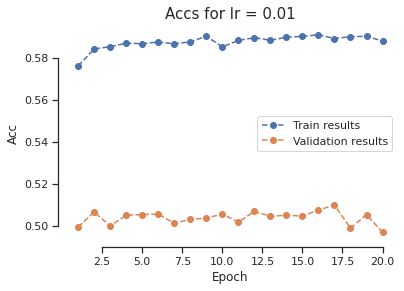

best val_loss: 1.675714635848999 at epoch: 16
best val_acc: 0.5098 at epoch: 16


In [38]:
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr,momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)
num_epochs = 20

train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=None, verbose=False,scheduler=None)
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
     extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))